In [1]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import numpy as np



In [7]:
spd_data = np.load("cleandata.npy", allow_pickle=True)
spd_data_T = spd_data.T

In [8]:
gh = np.array([[1,2,3],[4,5,6]])
gh1 =gh.T
print(gh1)

[[1 4]
 [2 5]
 [3 6]]


In [9]:
print(spd_data.shape)
print(spd_data_T.shape)

(471, 1494)
(1494, 471)


Elbow method

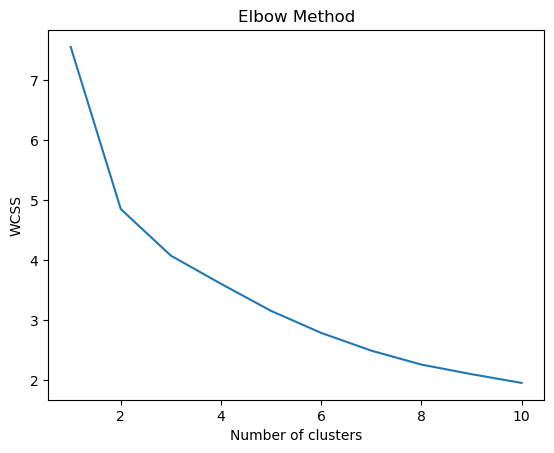

In [10]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(spd_data_T)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


Silhouette Coefficient

In [11]:
# 为聚类结果保存轮廓系数
silhouette_scores = []

# 选择聚类数从2到10
for n_clusters in range(2, 11):
    # 计算KMeans聚类
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(spd_data_T)

    # 计算轮廓系数
    silhouette_avg = silhouette_score(spd_data_T, cluster_labels)

    # 将轮廓系数保存到列表中
    silhouette_scores.append(silhouette_avg)

# 找到具有最大轮廓系数的聚类数
best_n_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

print("Best number of clusters:", best_n_clusters)


/opt/anaconda3/envs/ForEXE/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/ForEXE/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/ForEXE/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/ForEXE/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt

Best number of clusters: 2


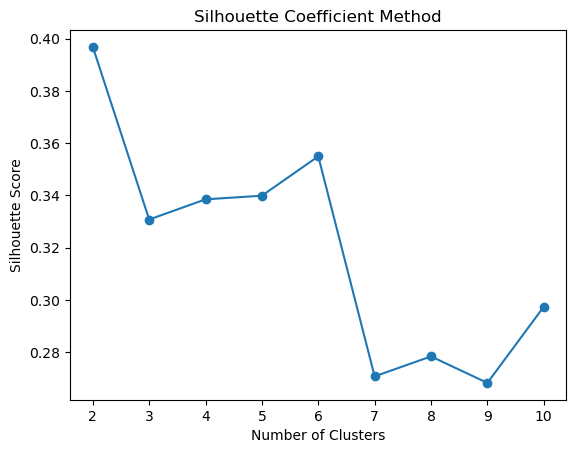

In [12]:
plt.plot(range(2,11), silhouette_scores, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Coefficient Method')
plt.show()


kmeans

In [96]:
n_clusters = 2  # 通过肘部法则或轮廓系数法确定的最佳聚类数

kmeans = KMeans(n_clusters=n_clusters)  # 初始化KMeans模型
kmeans.fit(spd_data_T)  # 对数据集进行聚类

cluster_labels = kmeans.labels_  # 获取每个样本所属簇的标签


/opt/anaconda3/envs/ForEXE/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [97]:
cluster_labels.shape

(1494,)

In [69]:
spd_data.shape

(471, 1494)

In [100]:
n = 471
cluster_data1 = np.empty([0,n])
cluster_data2 = np.empty([0,n])

for i in cluster_labels:
    if i == 0:
        cluster_data1 = np.vstack([cluster_data1, spd_data_T[i]])
    if i == 1:
        cluster_data2 = np.vstack([cluster_data2, spd_data_T[i]])


In [101]:
print(cluster_data1.shape)
print(cluster_data2.shape)

(904, 471)
(590, 471)


In [27]:
class SPDRePCA:
    def __init__(self, spd_data, n_components, wavelengths, mu, sigma):
        self.data = spd_data
        self.n_components = n_components
        self._pca = PCA(n_components=self.n_components)
        self.wavelengths = wavelengths
        self.mu = mu
        self.sigma = sigma

    def Reconstructed_spectrum(self):
        self.scores = self._pca.fit_transform(self.data)
        self.filters = np.zeros((len(self.mu), len(self.wavelengths)))
        for i in range(8):
            self.filters[i] = np.exp(-0.5 * ((self.wavelengths - self.mu[i]) / self.sigma[i])**2)
        self.M = np.dot(self.filters, self.scores)
        self.response_matrix = np.dot(self.filters, self.data)
        self.mean_response = np.mean(self.response_matrix, axis=1)
        self.mean_response = self.mean_response.reshape(-1, 1)
        self.M_inv = np.linalg.inv(self.M)
        response_diff = self.response_matrix - self.mean_response
        self.a_hat = np.dot(self.M_inv, response_diff)
        mean_spd = np.mean(self.data, axis=1)
        self.reconstructed_spectrum = np.dot(self.scores, self.a_hat) + mean_spd[:, np.newaxis]
        return self.reconstructed_spectrum , self.scores, self.a_hat

    def Plot(self, Light):
        # 创建一个包含三个子图的图像
        fig, axs = plt.subplots(3, 1)
        s = self.data[:,Light]
        r = self.reconstructed_spectrum[:,Light]

        # 绘制真实光谱图
        axs[0].plot(self.wavelengths, s, label='True Spectrum')
        axs[0].set_xlabel('Wavelength (nm)')
        axs[0].set_ylabel('Intensity')
        axs[0].set_title('True Spectrum vs Reconstructed Spectrum')
        axs[0].legend()

        # 绘制重建光谱图
        axs[1].plot(self.wavelengths, r, label='Reconstructed Spectrum')
        axs[1].set_xlabel('Wavelength (nm)')
        axs[1].set_ylabel('Intensity')
        axs[1].legend()

        # 绘制重建光谱和真实光谱叠加的图
        axs[2].plot(self.wavelengths, s, label='True Spectrum')
        axs[2].plot(self.wavelengths, r, label='Reconstructed Spectrum')
        axs[2].set_xlabel('Wavelength (nm)')
        axs[2].set_ylabel('Intensity')
        axs[2].legend()

        plt.tight_layout()
        plt.show()

    def Evaluate(self, light):
        s = self.data[:, light]
        s_re = self.reconstructed_spectrum[:,light]
        MAE = np.mean(np.absolute(s - s_re))
        RMSE = np.sqrt(np.mean(np.square(s- s_re)))
        RRMSE = RMSE / np.mean(s_re)

        #GFC
        num = abs(np.sum(s * s_re))
        denom_s = np.sqrt(np.sum(s ** 2) + 1e-9)
        denom_s_re = np.sqrt(np.sum(s_re ** 2) + 1e-9)
        GFC =num / (denom_s * denom_s_re)

        print("MAE: ", MAE)
        print("RMSE: ", RMSE)
        print("RRMES: ", RRMSE)
        print("GFC: ", GFC)

In [ ]:

wavelengths = np.arange(360, 831)
mu = np.array([415, 445, 480, 515, 555, 590, 630, 680])
sigma = np.array([11.0403, 12.7388, 15.2866, 16.5605, 16.5605, 16.9851, 21.2314, 22.0807])
r = SPDRePCA(spd, 8, wavelengths, mu, sigma)
r.Reconstructed_spectrum()
#r.Plot(103)
#r.Evaluate(103)
print(r.a_hat.shape)

In [35]:
cluster_dict = {}
cluster_dict['cluster1'] = cluster_data1
cluster_dict['cluster2'] = cluster_data2


In [69]:
class SPDReCluster:
    def __init__(self, spd):
        self.data = spd #(471,1494)
        self.data_T = spd.T
        self.best_n_clusters = None
        self.labels_ = None
        self.Group = None
        self.A_hat = None
        self.mu = np.array([415, 445, 480, 515, 555, 590, 630, 680])
        self.sigma = np.array([11.0403, 12.7388, 15.2866, 16.5605, 16.5605, 16.9851, 21.2314, 22.0807])
        self.wavelengths = np.arange(360, 831)

    
    def clusternumber(self):
        # 为聚类结果保存轮廓系数
        silhouette_scores = []
        # 选择聚类数从2到10
        for n_clusters in range(2, 11):
            # 计算KMeans聚类
            kmeans = KMeans(n_clusters=n_clusters, n_init=10 ,random_state=0)
            cluster_labels = kmeans.fit_predict(self.data_T)
            # 计算轮廓系数
            silhouette_avg = silhouette_score(self.data_T, cluster_labels)
            # 将轮廓系数保存到列表中
            silhouette_scores.append(silhouette_avg)
        # 找到具有最大轮廓系数的聚类数
        self.best_n_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

    def fit(self):
        self.model = KMeans(self.best_n_clusters, n_init=10)
        self.model.fit(self.data_T)
        self.labels_ = self.model.labels_
        

    def divideData(self):
        self.Group = {}  # 定义一个空字典
        # 根据需求动态命名变量并添加到字典中
        for i in range(self.best_n_clusters):
            variable_name = f"Cluster_{i}"  # 构造变量名
            n = 471
            cluster_data = np.empty([0,n])
            for k in self.labels_:
                if k == i:
                    cluster_data = np.vstack([cluster_data, self.data_T[i]])
            self.Group[variable_name] = cluster_data.T  # 添加到字典中
        
        #融合两个cluster, 重构SPDdata
        clusted_spd_Datalist =[]
        for k in self.Group.keys():
            clusted_spd_Datalist.append(self.Group[k])
        self.combined_spd = np.concatenate(clusted_spd_Datalist, axis=1)


    
    def compute(self, n_components):
        self.A_hat_dict = {}
        self.REconstruct = {}
    
        key_name = self.Group.keys()
        for group_name in key_name:
            cluster_temp_data = self.Group[group_name]
            spectrum = SPDRePCA(cluster_temp_data, n_components, self.wavelengths, self.mu, self.sigma)
            spectrum.Reconstructed_spectrum()
            a_hat = spectrum.a_hat
            self.A_hat_dict[group_name] = a_hat
            self.REconstruct[group_name] = spectrum.reconstructed_spectrum
        
        #merge
        clusted_REspd_Datalist =[]
        for k in self.REconstruct.keys():
            clusted_REspd_Datalist.append(self.Group[k])
        self.combined_REspd = np.concatenate(clusted_REspd_Datalist, axis=1)

         
    def Plot(self, Light):
        # 创建一个包含三个子图的图像
        fig, axs = plt.subplots(3, 1)
        s = self.combined_spd[:,Light]
        r = self.combined_REspd[:,Light]

        # 绘制真实光谱图
        axs[0].plot(self.wavelengths, s, label='True Spectrum')
        axs[0].set_xlabel('Wavelength (nm)')
        axs[0].set_ylabel('Intensity')
        axs[0].set_title('True Spectrum vs Reconstructed Spectrum')
        axs[0].legend()

        # 绘制重建光谱图
        axs[1].plot(self.wavelengths, r, label='Reconstructed Spectrum')
        axs[1].set_xlabel('Wavelength (nm)')
        axs[1].set_ylabel('Intensity')
        axs[1].legend()

        # 绘制重建光谱和真实光谱叠加的图
        axs[2].plot(self.wavelengths, s, label='True Spectrum')
        axs[2].plot(self.wavelengths, r, label='Reconstructed Spectrum')
        axs[2].set_xlabel('Wavelength (nm)')
        axs[2].set_ylabel('Intensity')
        axs[2].legend()

        plt.tight_layout()
        plt.show()

    def Evaluate(self, Light):
        s = self.combined_spd[:,Light]
        s_re = self.combined_REspd[:,Light]

        MAE = np.mean(np.absolute(s - s_re))
        RMSE = np.sqrt(np.mean(np.square(s- s_re)))
        RRMSE = RMSE / np.mean(s_re)

        #GFC
        num = abs(np.sum(s * s_re))
        denom_s = np.sqrt(np.sum(s ** 2) + 1e-9)
        denom_s_re = np.sqrt(np.sum(s_re ** 2) + 1e-9)
        GFC =num / (denom_s * denom_s_re)

        print("MAE: ", MAE)
        print("RMSE: ", RMSE)
        print("RRMES: ", RRMSE)
        print("GFC: ", GFC)



    def predict(self, new_data):
        if len(new_data.shape) == 1:
            new_data = new_data.reshape(1, -1)
        new_data_cluster = self.model.predict(new_data)[0]
        return new_data_cluster
    



In [72]:
x = SPDReCluster(spd_data)
x.clusternumber()
x.fit()
x.divideData()
x.compute(8)
sdf = x.predict(spd_data[:,1])
print(sdf)
print(x.labels_[1])

1
1


In [75]:
a1 = np.load("clustedSPD.npy",allow_pickle=True)
a2 = np.load("clustedRESPD.npy", allow_pickle= True)

In [77]:
import pandas as pd

df1 = pd.DataFrame(a1)

df1


,0,1,2,3,4,5,6,7,8,9,...,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493
0,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,...,0.000034,0.000034,0.000034,0.000034,0.000034,0.000034,0.000034,0.000034,0.000034,0.000034
1,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,...,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024
2,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,0.000024,...,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028
3,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,...,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028
4,0.000027,0.000027,0.000027,0.000027,0.000027,0.000027,0.000027,0.000027,0.000027,0.000027,...,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
467,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
468,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
469,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
dsf = x.A_hat_dict
for i in dsf.keys():
    test0 = dsf[i].mean(axis = 1)
    print(test0.shape)




(8,)
(8,)


In [59]:
group = x.Group 
for i in group.keys():
    test0 = group[i]
    print(test0.shape)

(471, 590)
(471, 904)


In [55]:
ttt =  spd_data[:,1]


(471,)